## TensorFlow model generation

This is a regular notebook structure - run each cell in order

In [7]:
import tensorflow as tf
import pickle
import numpy as np

from shared_project_functions import get_target_subdirectory

### Preprocessed data loading

Provide model name - must be the same as what you used in preprocessing step

In [8]:
base_corpus = "shakespeare"

dir = get_target_subdirectory(base_corpus, subdir_string="model")

#Load preprocessed data from subdirectory
with open(f"{dir}/{base_corpus}_preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]
    word_to_id = data["word_to_id"]
    id_to_word = data["id_to_word"],
    max_seq_length = data["max_seq_length"]

In [13]:
# Check and choose devices

print("Built with CUDA:", tf.test.is_built_with_cuda())

# Low-level build info (helpful to debug mismatches)
print("TF:", tf.__version__)
try:
    build = tf.sysconfig.get_build_info()
    print("TF build info (keys):", list(build.keys()))
    print("CUDA version (TF expects):", build.get("cuda_version"))
    print("cuDNN version (TF expects):", build.get("cudnn_version"))
except Exception as e:
    print("Build info not available:", e)

print("Logical GPUs:  ", tf.config.list_logical_devices('GPU'))
print("Physical GPUs: ", tf.config.list_physical_devices('GPU'))

Built with CUDA: True
TF: 2.20.0
TF build info (keys): ['cpu_compiler', 'cuda_compute_capabilities', 'cuda_version', 'cudnn_version', 'is_cuda_build', 'is_rocm_build', 'is_tensorrt_build']
CUDA version (TF expects): 12.5.1
cuDNN version (TF expects): 9
Logical GPUs:   [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Physical GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Define model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Model hyperparameters
vocab_size = len(word_to_id)
embedding_dim = 256  # The size of the word vectors
rnn_units = 1024     # The number of units in the LSTM layer
dropout = 0.2       # Dropout rate for regularization

model = Sequential([
    # Embedding layer: Converts integer IDs to dense vectors
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_seq_length),

    # LSTM layer: The core of the model for learning sequence patterns
    LSTM(rnn_units, return_sequences=True),
    Dropout(dropout), # Dropout for regularization

    LSTM(rnn_units),
    Dropout(dropout), # Another dropout layer

    # Dense layer: Maps the LSTM output to the vocabulary
    Dense(vocab_size, activation='softmax')
])

In [15]:
# Compile model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print a summary of model to see layers and parameter count
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Convert training lists to numpy arrays
x_train_np = np.array(X_train)
y_train_np = np.array(y_train)


# Train the model and save the training history
history = model.fit(
    x_train_np,
    y_train_np,
    epochs=10,
    batch_size=128
)

# Save the trained model
model.save(f"{base_corpus}_model.keras")

#Save the training history to subdirectory
with open(f"{base_corpus}_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/10


E0000 00:00:1758040683.880033    3654 dnn.cc:935] CUDNN_STATUS_EXECUTION_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(2039): 'cudnnRNNForward( cudnn.handle(), rnn_desc.handle(), rnn_fwd_mode, reinterpret_cast<const int*>(seq_lengths_data.opaque()), input_desc.data_handle(), input_data.opaque(), output_desc.data_handle(), output_data->opaque(), input_h_desc.handle(), input_h_data.opaque(), output_h_data->opaque(), input_c_desc.handle(), input_c_data.opaque(), output_c_data->opaque(), rnn_desc.ParamsSizeInBytes(), params.opaque(), workspace.size(), workspace.opaque(), reserve_space.size(), reserve_space.opaque())'
2025-09-16 12:38:03.880070: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at cudnn_rnn_ops.cc:1776 : INTERNAL: Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 256, 1024, 1, 20, 128, 1024

InternalError: Graph execution error:

Detected at node sequential_1_1/lstm_2_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.13/asyncio/base_events.py", line 683, in run_forever

  File "/usr/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once

  File "/usr/lib/python3.13/asyncio/events.py", line 89, in _run

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 508, in process_one

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_3505/1792240866.py", line 7, in <module>

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/sequential.py", line 220, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/function.py", line 206, in _run_through_graph

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/functional.py", line 644, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 256, 1024, 1, 20, 128, 1024] 
	 [[{{node sequential_1_1/lstm_2_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_6374]

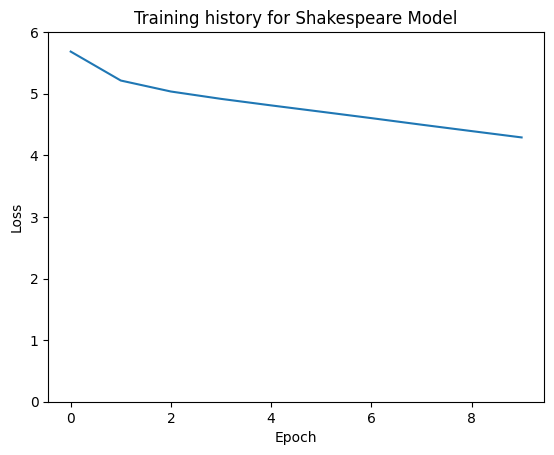

In [8]:
#display history
import matplotlib.pyplot as plt

#load history file from subdirectory
with open(f"{dir}/{base_corpus}_training_history.pkl", "rb") as f:
    history = pickle.load(f)
    
#Y-axis limit for loss plot
plt.ylim(0, np.ceil(max(history['loss'])))

#Tile and labels
plt.title(f'Training history for {base_corpus.capitalize()} Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history['loss'], label='loss')